In [1]:
import importlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from argparse import Namespace
from logging import warning
import os.path as osp

from torch_geometric.graphgym.config import cfg, dump_cfg, set_cfg, load_cfg
from torch_geometric.graphgym.loader import create_loader
from torch_geometric.graphgym.model_builder import create_model
from torch_geometric.graphgym.loss import compute_loss

from graphgps.finetuning import load_pretrained_model_cfg, init_model_from_pretrained

/home/jonas/miniconda3/envs/exphormer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jonas/miniconda3/envs/exphormer/lib/python3.9/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [2]:
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

11.3
False
True


In [3]:
# CONFIGURATION

dataset = 'Cifar10'

args = Namespace(
    cfg_file = f'configs/Small-experiment/{dataset}/GPS+SparseAttention.yaml',
    repeat = 1,
    mark_done = False,
    opts=[],
)

set_cfg(cfg)
load_cfg(cfg, args)
dump_cfg(cfg)

# Adapt configuration
if hasattr(cfg, 'pretrained_dir'):
    warning.warn(f"cfg has pretrained_dir {cfg.pretrained_dir}, which we are not using")
cfg.pretrained.dir = f'results/{dataset}/GPS+SparseAttention/'   # None to use random initialization
if cfg.device == 'auto':
    cfg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {cfg.device}")

cfg = load_pretrained_model_cfg(cfg)

# Set Pytorch environment
torch.set_num_threads(cfg.num_threads)

Using device: cpu


In [4]:
# LOADER
loaders = create_loader()

loader = loaders[0]
split = 'test'

100%|██████████| 60000/60000 [02:16<00:00, 438.60it/s]


In [5]:

# MODEL
model = create_model()
if cfg.pretrained.dir:
    model = init_model_from_pretrained(
        model, cfg.pretrained.dir, freeze_main=False,
        reset_prediction_head=False, device=cfg.device
    )


model.eval()

GPSModel(
  (encoder): FeatureEncoder(
    (node_encoder): Concat2NodeEncoder(
      (encoder1): LinearNodeEncoder(
        (encoder): Linear(in_features=5, out_features=40, bias=True)
      )
      (encoder2): EquivStableLapPENodeEncoder(
        (linear_encoder_eigenvec): Linear(in_features=8, out_features=40, bias=True)
      )
    )
    (edge_encoder): LinearEdgeEncoder(
      (encoder): Linear(in_features=1, out_features=40, bias=True)
    )
  )
  (layers): Sequential(
    (0): GPSLayer(
      summary: dim_h=40, local_gnn_type=CustomGatedGCN, global_model_type=SparseAttention, heads=4
      (local_model): GatedGCNLayer()
      (self_attn): SparseAttention(
        (MQs): Linear(in_features=40, out_features=160, bias=True)
        (MKs): Linear(in_features=40, out_features=160, bias=True)
        (MVs): Linear(in_features=40, out_features=160, bias=True)
        (MO): Linear(in_features=160, out_features=40, bias=True)
      )
      (norm1_local): BatchNorm1d(40, eps=1e-05, momentu

In [6]:
print(len(loaders))
# print(len(loggers))
print(loaders[0].dataset.data.x.shape)
print(loaders[0].dataset.data.y.shape)
print(loaders[1].dataset.data.x.shape)
print(loaders[1].dataset.data.y.shape)
print(loaders[2].dataset.data.x.shape)
print(loaders[2].dataset.data.y.shape)

# find the difference between the two loaders
print(torch.all(loaders[0].dataset.data.x == loaders[2].dataset.data.x))
print(torch.all(loaders[0].dataset.data.y == loaders[2].dataset.data.y))


3
torch.Size([7058005, 5])
torch.Size([60000])
torch.Size([7058005, 5])
torch.Size([60000])
torch.Size([7058005, 5])
torch.Size([60000])
tensor(True)
tensor(True)


In [22]:
from graphgps.loss.subtoken_prediction_loss import subtoken_cross_entropy

def arxiv_cross_entropy(pred, true, split_idx):
    true = true.squeeze(-1)
    if pred.ndim > 1 and true.ndim == 1:
        pred_score = F.log_softmax(pred[split_idx], dim=-1)
        loss =  F.nll_loss(pred_score, true[split_idx])
    else:
        raise ValueError("In ogbn cross_entropy calculation dimensions did not match.")
    return loss, pred_score

loader = loaders[0]
split = 'test'

i = -1
for batch in loader:
    i += 1
    if i%20 == 0:
        print("processing batch", i)
    batch.split = split
    
    if cfg.gnn.head == 'inductive_edge':
        pred, true, extra_stats = model(batch)
    else:
        pred, true = model(batch)
        extra_stats = {}
    
    if cfg.dataset.name == 'ogbg-code2':
        loss, pred_score = subtoken_cross_entropy(pred, true)
        _true = true
        _pred = pred_score
    elif cfg.dataset.name == 'ogbn-arxiv':
        index_split = loader.dataset.split_idx[split].to(torch.device(cfg.device))
        loss, pred_score = arxiv_cross_entropy(pred, true, index_split)
        _true = true[index_split].detach().to('cpu', non_blocking=True)
        _pred = pred_score.detach().to('cpu', non_blocking=True)
    else:
        loss, pred_score = compute_loss(pred, true)
        _true = true.detach().to('cpu', non_blocking=True)
        _pred = pred_score.detach().to('cpu', non_blocking=True)

In [22]:
# What could we want to plot?
# - visualize graphs
# - homophily metric
# - correspondence with given graph
# - how does this all work when using multiple heads?


# lists of length num_graphs, containing tensors of shape (num_tokens, num_features)
# tokens: num_graphs, (num_tokens, num_features)
# labels: num_graphs, (num_tokens,)


from typing import Callable, Dict

from graphgps.layer.gps_layer import GPSLayer


class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.tokens = {}
        self.labels = {}
        self.edge_idxs = {}
        self.attn_layers = {}
        self.hooks = []

        for name, module in model.named_modules():
            if isinstance(module, GPSLayer):
                self.hooks.append(
                    module.self_attn.register_forward_hook(
                        self.save_tokens_labels_hook(name, module.global_model_type)
                    )
                )
                self.tokens[name] = []
                self.labels[name] = []
                self.edge_idxs[name] = []
                self.attn_layers[name] = module.self_attn

    def save_tokens_labels_hook(self, layer_name: str, global_model_type: str) -> Callable:
        def hook(module: nn.Module, input, output):
            if global_model_type in ('Transformer',):
                # input is 3-tuple (x,x,x)
                # output is a tuple (output, None)
                assert type(input) == type(output) == tuple, f"input: {type(input)}\noutput: {type(output)}"
                assert len(input) == 3 and len(output) == 2, f"input: {len(input)}\noutput: {len(output)}"
                input = input[0]
                output = output[0]
            
            elif global_model_type in ('SparseAttention',):
                assert type(input) == tuple, f"input: {type(input)}"
                global mymodule
                mymodule = module
                global myinput
                myinput = input
                global myoutput
                myoutput = output
                assert len(input) == 2, f"input: {len(input)}"
                assert type(output) == torch.Tensor, f"output: {type(output)}"
                input = input[0]

            elif global_model_type in ['Performer', 'BigBird']:
                pass

            # input: (batch_size, num_tokens, num_features)
            assert input.ndim == 3
            assert output.ndim == 3
            B = input.shape[0]
            for b in range(B):
                self.tokens[layer_name].append(input[b])
                self.labels[layer_name].append(output[b])
        return hook
    
    def remove_all_hooks(self):
        for hook in self.hooks:
            hook.remove()

# to ensure that the hooks are removed when we re-run this cell
if 'myFeatureExtractor' in locals():
    myFeatureExtractor.remove_all_hooks()

myFeatureExtractor = FeatureExtractor(model)

for name, module in model.named_modules():
    for key, hook in module._forward_hooks.items():
        print(name, ":", key, hook)

layers.0.self_attn : 47 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7fb6f7e28a60>
layers.1.self_attn : 48 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7fb857350430>
layers.2.self_attn : 49 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7fb857350790>
layers.3.self_attn : 50 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7fb75b5a2700>
layers.4.self_attn : 51 <function FeatureExtractor.save_tokens_labels_hook.<locals>.hook at 0x7fb75b540790>


In [18]:
print(type(myinput), len(myinput))
print(type(myoutput), len(myoutput))

for x in myinput:
    print(type(x), end="")
print()
print(myinput[0].shape)
print(len(myinput[1]))
print(myinput[1][0].shape)

print(model.layers[0].pass_edge_index)

<class 'tuple'> 2
<class 'torch.Tensor'> 16
<class 'torch.Tensor'><class 'list'>
torch.Size([16, 122, 40])
16
torch.Size([2, 880])
True


In [11]:
print(type(mymodule))

<class 'graphgps.layer.sparse_attention_layer.SparseAttention'>


TypeError: forward() missing 1 required positional argument: 'edge_idxs'

In [23]:
# run the model on the first 100 graphs, and save the tokens and labels

from graphgps.utils import batch_to_edge_idxs


num_graphs = 0
for i, batch in enumerate(loader):
    batch.split = 'test'
    if num_graphs > 100:
        break
    num_graphs += batch.num_graphs

    edge_idxs = batch_to_edge_idxs(batch)
    assert len(edge_idxs) == batch.num_graphs
    for b in range(batch.num_graphs):
        for layer in myFeatureExtractor.edge_idxs.keys():
            myFeatureExtractor.edge_idxs[layer].append(edge_idxs[b])

    pred, true = model(batch)

In [24]:
for layer in myFeatureExtractor.tokens.keys():
    print(layer, len(myFeatureExtractor.tokens[layer]), len(myFeatureExtractor.labels[layer]), len(myFeatureExtractor.edge_idxs[layer]))

layers.0 112 112 112
layers.1 112 112 112
layers.2 112 112 112
layers.3 112 112 112
layers.4 112 112 112


torch.Size([1, 4, 123, 10])
torch.Size([1, 4, 123, 10])
torch.Size([1, 4, 123, 10])
torch.Size([1, 4, 123, 10])
torch.Size([1, 4, 123, 10])


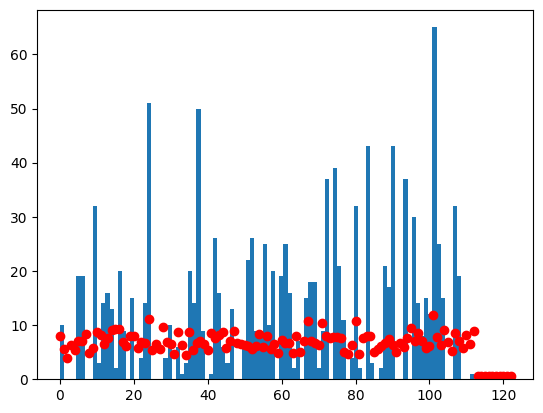

In [25]:
import math
from graphgps.layer.sparse_attention_layer import SparseAttention

from matplotlib import pyplot as plt

for layer_name in myFeatureExtractor.tokens.keys():
    token_list = myFeatureExtractor.tokens[layer_name]  # list of tensors, one for each graph
    label_list = myFeatureExtractor.labels[layer_name]  # list of tensors, one for each graph
    attn = myFeatureExtractor.attn_layers[layer_name]
    edge_idxs = myFeatureExtractor.edge_idxs[layer_name]
    
    if isinstance(attn, SparseAttention):
        # [**, N, dim]
        x = token_list[0].unsqueeze(0)

        # [**, num_heads, N, kq_dim]
        queries = attn.split_heads(attn.MQs(x), small_dim=attn.kq_dim)
        keys = attn.split_heads(attn.MKs(x), small_dim=attn.kq_dim)
        # [**, num_heads, N, val_dim]
        values = attn.split_heads(attn.MVs(x), small_dim=attn.val_dim)

        # [**, num_heads, N, k]
        nearest_key_indices = attn.nearest_k_keys(queries, keys)
        print(nearest_key_indices.shape)

        # the k keys nearest to each query
        # [**, num_heads, N, k, kq_dim]
        nearest_keys = torch.gather(
            input=keys.unsqueeze(-2).expand(
                *keys.shape[:-1], attn.k, attn.kq_dim
            ),  # [**, num_heads, N, k, kq_dim]
            dim=-3,
            index=nearest_key_indices.unsqueeze(-1).expand(
                *nearest_key_indices.shape, attn.kq_dim
            ),  # [**, num_heads, N, k, kq_dim]
            # sparse_grad=True,
        )

        # [**, num_heads, N, k, kq_dim]
        queries_extended = queries.unsqueeze(-2).expand(
            *queries.shape[:-1], attn.k, attn.kq_dim
        )

        # [**, num_heads, N, k]
        largest_attention_weights = (queries_extended * nearest_keys).sum(
            -1
        ) / math.sqrt(attn.kq_dim)


plt.hist(nearest_key_indices[0][0].flatten(), bins=100)
plt.scatter(x=torch.arange(0,len(keys[0][0])), y=keys[0][0].detach().norm(dim=-1).flatten(), c='r')

<class 'dict'>


In [131]:
import networkx as nx

def vis_mip_attn_graph_multiple_heads(nearest_key_indices, largest_attention_weights, edge_idx):
    """
    args:
        nearest_key_indices: [num_heads, N, k]. nearest_key_indices[h][i][m]==j signifies there is an edge from j to i in head h.
    """

    H, N, k = nearest_key_indices.shape
    input_graph = nx.Graph()
    input_graph.add_edges_from(edge_idx.t().tolist())
    pos = nx.spring_layout(input_graph)

    # draw the input graph
    height = 5
    fig, axs = plt.subplots(1, H+1, figsize=((H+1+0.2)*height,height), gridspec_kw={'width_ratios': [1]*(H+1)})
    nx.draw_networkx_nodes(input_graph, pos, node_size=200, node_color='skyblue', ax=axs[0])
    nx.draw_networkx_labels(input_graph, pos, font_size=10, ax=axs[0])
    nx.draw_networkx_edges(input_graph, pos, edge_color='black', width=1, ax=axs[0])
    # axs[0].set_title("Input Graph") # caption above
    axs[0].text(0.5, -0.05, "Input Graph", ha='center', va='center', transform=axs[0].transAxes, fontsize=20*height/5)  # caption below

    # Reduce spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0)

    # plotting stuff
    norm = plt.Normalize(vmin=largest_attention_weights.min(), vmax=largest_attention_weights.max())
    cmap = plt.cm.plasma

    for h in range(H):
        print(f"head {h+1}/{H}")
        ax = axs[h+1]
        vis_mip_attn_graph(input_graph, pos, nearest_key_indices[h], largest_attention_weights[h], ax=ax, norm=norm, cmap=cmap)
        # ax.set_title(f"Head {h+1}") # caption above
        axs[h+1].text(0.5, -0.05, f"Head {h+1}", ha='center', va='center', transform=axs[h+1].transAxes, fontsize=20*height/5)  # caption below

    # Add a color bar to show the mapping of weights to colors
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for the colorbar
    cbar = fig.colorbar(sm, ax=axs, orientation='vertical', pad=0, label='Edge Weight')

    plt.show()



def vis_mip_attn_graph(input_graph: nx.DiGraph, pos, nearest_key_indices, largest_attention_weights, ax: plt.Axes, norm: plt.Normalize, cmap: plt.cm):
    """
    args:
        nearest_key_indices: [N, k]. nearest_key_indices[i][m]==j signifies there is an edge from j to i in head h.
    """

    N, k = nearest_key_indices.shape
    G = nx.DiGraph()
    for i in range(N):
        for m in range(3):
            weight = largest_attention_weights[i][m].item()
            G.add_edge(nearest_key_indices[i][m].item(), i, weight=weight)

    # get weights and map to colors
    weights = nx.get_edge_attributes(G, 'weight')
    edge_colors = [cmap(norm(weights[edge])) for edge in G.edges()]

    # draw the graph with edge colors
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=.5, ax=ax)
    # nx.draw_networkx_edges(input_graph, pos, edge_color='black', width=1, ax=ax)

    return G

head 1/4
head 2/4
head 3/4
head 4/4


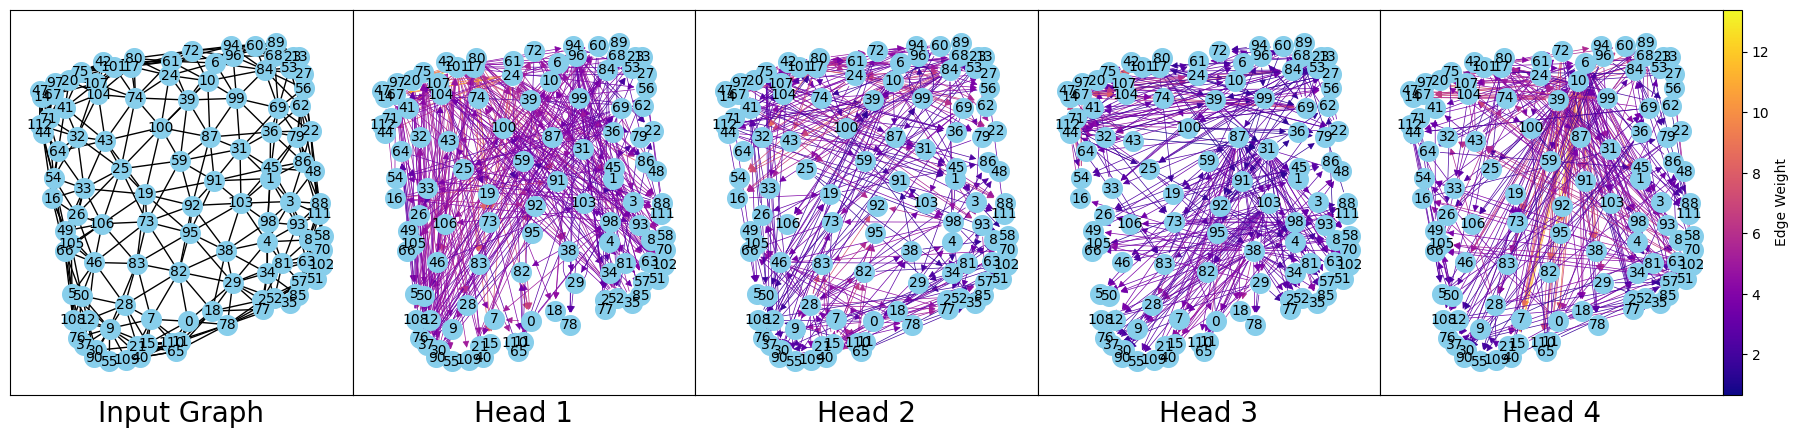

In [133]:
fake_nodes = keys[0][0].norm(dim=-1) == keys[0][0].norm(dim=-1)[-1]

G = vis_mip_attn_graph_multiple_heads(nearest_key_indices[0, :, ~fake_nodes, :], largest_attention_weights[0, :, ~fake_nodes, :], edge_idxs[0])

{101: 65, 0: 7, 80: 32, 24: 51, 107: 32, 74: 19, 84: 43, 72: 37, 64: 7, 56: 23, 54: 9, 1: 3, 16: 20, 43: 16, 61: 25, 22: 4, 2: 0, 94: 33, 96: 30, 68: 18, 69: 18, 39: 9, 99: 15, 53: 9, 10: 32, 3: 0, 100: 12, 4: 0, 17: 9, 42: 26, 67: 15, 5: 19, 97: 14, 75: 20, 14: 13, 47: 9, 20: 15, 89: 17, 13: 16, 76: 21, 6: 19, 102: 25, 37: 49, 108: 19, 12: 14, 51: 22, 90: 43, 52: 26, 50: 7, 7: 0, 98: 8, 11: 3, 29: 4, 34: 3, 8: 0, 60: 19, 9: 0, 23: 14, 57: 10, 70: 2, 71: 9, 44: 6, 58: 20, 35: 20, 30: 10, 63: 2, 77: 11, 104: 15, 62: 16, 15: 2, 93: 4, 46: 4, 88: 21, 18: 0, 19: 0, 85: 3, 21: 0, 36: 14, 45: 3, 25: 0, 79: 4, 26: 0, 27: 0, 28: 0, 87: 2, 31: 0, 32: 6, 81: 2, 33: 1, 38: 1, 40: 0, 41: 1, 48: 0, 49: 0, 55: 2, 59: 0, 65: 0, 66: 0, 73: 0, 112: 1, 78: 0, 82: 0, 83: 0, 86: 0, 91: 0, 92: 0, 95: 0, 103: 0, 105: 0, 106: 0, 109: 0, 110: 0, 111: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0}
[(101, 65), (24, 51), (37, 49), (84, 43), (90, 43), (72, 37), (94, 33), (80, 3

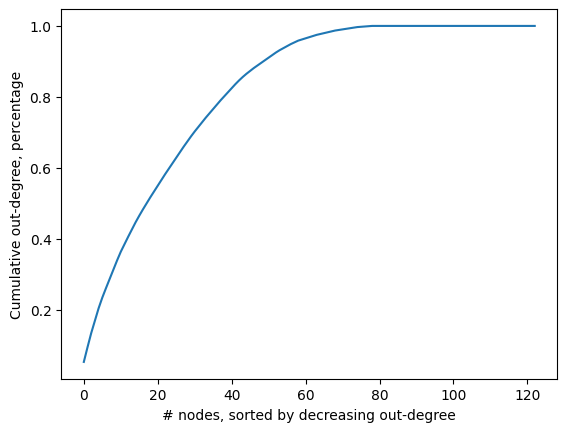

In [136]:
N, k = nearest_key_indices[0][0].shape
G = nx.DiGraph()
for i in range(N):
    for m in range(k):
        weight = largest_attention_weights[0][0][i][m].item()
        G.add_edge(nearest_key_indices[0][0][i][m].item(), i, weight=weight)

out_degrees = dict(G.out_degree())
print(out_degrees)
sorted_out_degrees = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)
print(sorted_out_degrees)

# plot a graph that shows how much the out_degrees are concentrated in the nodes with the highest out_degree
# x-axis: percentage of nodes, y-axis: percentage of out_degree

out_degrees = [out_degrees[i] for i in range(len(out_degrees))]
out_degrees = sorted(out_degrees, reverse=True)
print(out_degrees)
print(sum(out_degrees))

cumulative_out_degrees = [sum(out_degrees[:i+1]) for i in range(len(out_degrees))]
cumulative_out_degrees = [x/sum(out_degrees) for x in cumulative_out_degrees]
print(cumulative_out_degrees)

plt.plot(cumulative_out_degrees)
plt.ylabel("Cumulative out-degree, percentage")
plt.xlabel("# nodes, sorted by decreasing out-degree")
plt.show()

InDegreeView({0: 0, 1: 1})

In [138]:
from sklearn.decomposition import PCA
import numpy as np

# Assume queries and keys are your input tensors of shape [N, D]
# Example:
# queries = torch.randn(100, 64)  # 100 embeddings of dimension 64
# keys = torch.randn(100, 64)     # 100 embeddings of dimension 64

# normalize largest_attention_weights[0][0] to get edge weights
edge_weights = largest_attention_weights[0][0].clone()
edge_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

# Convert to NumPy arrays
queries_np = queries[0][0].detach().numpy()[~fake_nodes[0]]
keys_np = keys[0][0].detach().numpy()[~fake_nodes[0]]
nearest_key_indices_np = nearest_key_indices[0][0].numpy()[~fake_nodes[0]]

# Concatenate the queries and keys
embeddings = np.concatenate((queries_np, keys_np), axis=0)

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Split the PCA-transformed data back into queries and keys
queries_pca = embeddings_pca[:queries_np.shape[0], :]
keys_pca = embeddings_pca[queries_np.shape[0]:, :]
print(queries_pca.shape)
print(keys_pca.shape)

# Plot the PCA results
plt.figure(figsize=(8, 8))
plt.scatter(queries_pca[:, 0], queries_pca[:, 1], color='blue', label='Queries')
plt.scatter(keys_pca[:, 0], keys_pca[:, 1], color='red', label='Keys')
plt.title('PCA of Queries and Keys Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Draw arrows
for i in range(keys_pca.shape[0]):
    for m in range(nearest_key_indices_np.shape[1]):
        j = nearest_key_indices_np[i, m]
        plt.arrow(
            x=queries_pca[i, 0], y=queries_pca[i, 1],
            dx=keys_pca[j, 0] - queries_pca[i, 0], dy=keys_pca[j, 1] - queries_pca[i, 1],
            color='black', alpha=0.2 * edge_weights[i, m].item()
        )


plt.legend()
plt.grid(True)
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[-0.7204544   1.1099681   0.8297127  -1.5162917   0.400123   -1.2508682
  1.2174963  -0.00911576  1.0615947   0.25125617  0.3098482  -0.6939993
  0.34121212  0.17467389  0.33471343  0.26925597  1.1969607  -0.6040357
  1.1112835  -0.8116781   1.6346363   0.21012884  1.4849293   0.29437968
 -1.0200245  -2.0692105  -1.0132982   0.7441844  -0.95733994  0.5235942
 -0.24018277 -1.1289568  -0.26942056  0.00260183  1.8223188  -0.39630258
 -0.13837796  0.23753482 -0.04152718  0.118976    0.33089596  1.1092635
  1.5618739  -0.20078944 -0.6087474  -0.08799954  0.8745543   0.30818924
  1.0911328   0.04252201  1.8743254   0.2277976   0.4144487  -1.1353889
 -0.47571185  0.1686227   0.0068613  -0.06697541  0.4234486  -0.45296186
 -0.89387095  0.24736384  1.6553147  -0.3824206  -0.89338386  0.26460367
  0.3475477  -2.4909146  -0.3363356  -0.02110217  0.8162666   0.41736507
  2.3280673   0.3914086  -0.6580932   0.1776064   0.25268507  0.37273395
  1.1731609   0.34258312].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

/home/jonas/miniconda3/envs/exphormer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jonas/miniconda3/envs/exphormer/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(105, 2)
(105, 2)


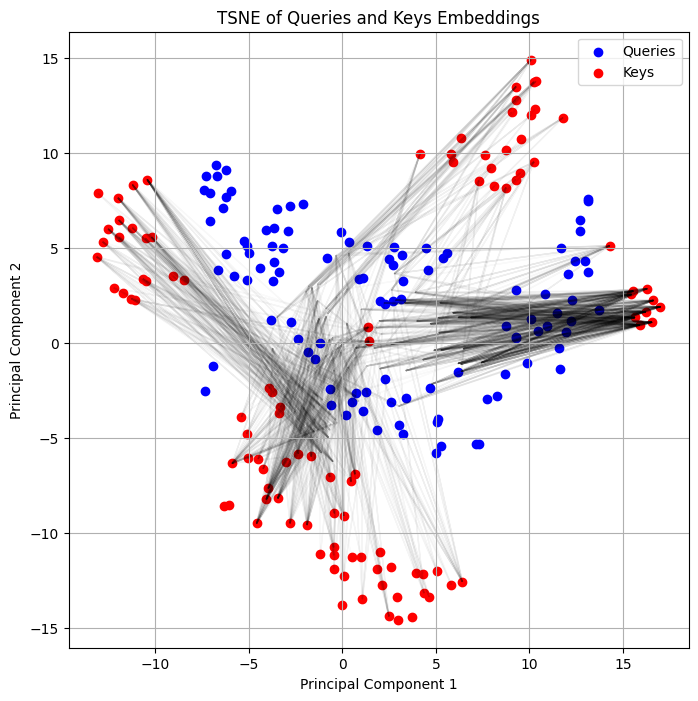

In [107]:
from sklearn.manifold import TSNE
import numpy as np

# Assume queries and keys are your input tensors of shape [N, D]
# Example:
# queries = torch.randn(100, 64)  # 100 embeddings of dimension 64
# keys = torch.randn(100, 64)     # 100 embeddings of dimension 64

# normalize largest_attention_weights[0][0] to get edge weights
edge_weights = largest_attention_weights[0][0].clone()
edge_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min())

# Convert to NumPy arrays
queries_np = queries[0][0].detach().numpy()[:105]
keys_np = keys[0][0].detach().numpy()[:105]
nearest_key_indices_np = nearest_key_indices[0][0].numpy()[:105]

# Concatenate the queries and keys
embeddings = np.concatenate((queries_np, keys_np), axis=0)

# Apply PCA to reduce dimensions to 2D
tsne = TSNE(n_components=2)
embeddings_tsne = tsne.fit_transform(embeddings)

# Split the PCA-transformed data back into queries and keys
queries_tsne = embeddings_tsne[:queries_np.shape[0], :]
keys_tsne = embeddings_tsne[queries_np.shape[0]:, :]
print(queries_tsne.shape)
print(keys_tsne.shape)

# Plot the PCA results
plt.figure(figsize=(8, 8))
plt.scatter(queries_tsne[:, 0], queries_tsne[:, 1], color='blue', label='Queries')
plt.scatter(keys_tsne[:, 0], keys_tsne[:, 1], color='red', label='Keys')
plt.title('TSNE of Queries and Keys Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Draw arrows
for i in range(keys_tsne.shape[0]):
    for m in range(nearest_key_indices_np.shape[1]):
        j = nearest_key_indices_np[i, m]
        plt.arrow(
            x=queries_pca[i, 0], y=queries_pca[i, 1],
            dx=keys_tsne[j, 0] - queries_pca[i, 0], dy=keys_tsne[j, 1] - queries_pca[i, 1],
            color='black', alpha=0.2 * edge_weights[i, m].item()
        )


plt.legend()
plt.grid(True)
plt.show()

array([[-1.3503120e+00, -2.6920779e+00],
       [-1.1446744e-01, -2.8154767e+00],
       [-1.2700746e+00, -4.5306916e+00],
       [ 2.0774260e+00,  5.4448932e-01],
       [-7.8135318e-01,  1.6186454e+00],
       [ 6.3725924e-01, -1.1259946e+00],
       [-1.8098649e+00, -1.1569797e+00],
       [ 2.3556910e+00,  5.8884542e-02],
       [-8.6776125e-01,  1.8420188e+00],
       [-3.0540937e-01, -1.2254201e-01],
       [ 1.7102467e+00, -3.0641237e-01],
       [-2.5304338e-01, -4.2112780e+00],
       [-4.0832877e-01, -1.9918108e+00],
       [ 1.1472456e+00,  7.8786135e-01],
       [-5.9990829e-01, -3.7235341e+00],
       [ 3.8859069e+00,  2.7274716e+00],
       [ 5.9173341e+00,  1.6083951e+00],
       [-2.8160753e+00, -3.1192584e+00],
       [ 7.4311531e-01, -3.8490510e-01],
       [ 7.4586072e+00, -1.0490401e+00],
       [-5.5819571e-01, -9.1974515e-01],
       [ 3.2942677e-01,  4.6966777e+00],
       [ 5.2910938e+00, -3.2766265e-01],
       [-2.3138641e-01,  3.0744085e-02],
       [ 1.84830

In [109]:
for name, submodule in model.named_modules():
    num_params = sum(p.numel() for p in submodule.parameters())
    print(f"Submodule: {name}, Number of parameters: {num_params}")

Submodule: , Number of parameters: 209535
Submodule: encoder, Number of parameters: 680
Submodule: encoder.node_encoder, Number of parameters: 600
Submodule: encoder.node_encoder.encoder1, Number of parameters: 240
Submodule: encoder.node_encoder.encoder1.encoder, Number of parameters: 240
Submodule: encoder.node_encoder.encoder2, Number of parameters: 360
Submodule: encoder.node_encoder.encoder2.linear_encoder_eigenvec, Number of parameters: 360
Submodule: encoder.edge_encoder, Number of parameters: 80
Submodule: encoder.edge_encoder.encoder, Number of parameters: 80
Submodule: layers, Number of parameters: 206805
Submodule: layers.0, Number of parameters: 41361
Submodule: layers.0.local_model, Number of parameters: 8481
Submodule: layers.0.local_model.A, Number of parameters: 1640
Submodule: layers.0.local_model.B, Number of parameters: 1640
Submodule: layers.0.local_model.C, Number of parameters: 1640
Submodule: layers.0.local_model.D, Number of parameters: 1640
Submodule: layers.0.

: 